# Predictive Uncertainty Estimation using Deep Ensemble (Regression)

## Dataset: Toy Dataset

This algorithm is implementation of paper [Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://arxiv.org/abs/1612.01474). In this jupyter notebook, I will implement regression part of this paper using 1D Toy Dataset (10sin(x) + $\epsilon$ where $\epsilon$ ~ N(0, 3^2) and N(0, 1^2)).<br>
**5 networks** will be used for ensemble 

## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Parameters of training
Learning_rate = 0.01
epsilon = 1e-8

num_iter = 5000
batch_size = 256

test_ratio = 0.1
gpu_fraction = 0.2

# Ensemble networks (5 networks)
networks = ['network1', 'network2', 'network3', 'network4', 'network5']

# Dense [input size, output size]
dense1 = [1, 256]
dense2 = [256, 512]
dense_mu  = [512, 1]
dense_sig = [512, 1]

## Making Toy Dataset 

Toy dataset is y = 10sin(x) + epsilon <br>
- If x < 0: $\epsilon$ = N(0, sigma1^2) -> In this example sigma1 = 3 
- If x > 0: $\epsilon$ = N(0, sigma2^2) -> In this example sigma2 = 1 

Train data shape: (1080, 1)
Test data shape: (121, 1)


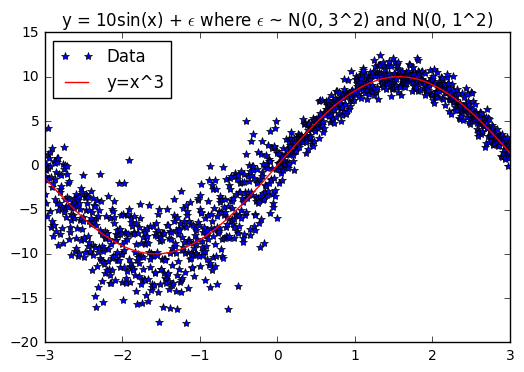

In [20]:
data_range = 3
data_step = 0.005
data_sigma1 = 3
data_sigma2 = 1
num_data = 1

data_x = np.arange(-data_range, data_range + data_step, data_step)
data_x = np.reshape(data_x, [data_x.shape[0], 1])

data_y = np.zeros([data_x.shape[0], 1])
data_y_true = np.zeros([data_x.shape[0], 1])

for i in range(data_x.shape[0]):
    if (data_x[i,0] < 0): 
        data_y[i, 0] = 10 * np.sin(data_x[i,0]) + np.random.normal(0, data_sigma1)
    else:
        data_y[i, 0] = 10 * np.sin(data_x[i,0]) + np.random.normal(0, data_sigma2)
        
    data_y_true[i, 0] = 10 * np.sin(data_x[i,0])
    
num_train_data = int(data_x.shape[0] * (1 - test_ratio))
num_test_data  = data_x.shape[0] - num_train_data

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

print("Train data shape: " + str(train_x.shape))
print("Test data shape: " + str(test_x.shape))

plt.plot(data_x, data_y, 'b*')
plt.plot(data_x, data_y_true, 'r')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.title('y = 10sin(x) + $\epsilon$ where $\epsilon$ ~ N(0, 3^2) and N(0, 1^2)')
plt.show()

## Functions

In [4]:
tf.reset_default_graph()

def weight_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)

def bias_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)

# Get networks
def get_network(network_name):
    input_x = tf.placeholder(tf.float64, shape = [None, 1])
    
    with tf.variable_scope(network_name):
        # Densely connect layer variables
        w_fc1 = weight_variable(network_name + '_w_fc1', dense1)
        b_fc1 = bias_variable(network_name + '_b_fc1', [dense1[1]])
        
        w_fc2 = weight_variable(network_name + '_w_fc2', dense2)
        b_fc2 = bias_variable(network_name + '_b_fc2', [dense2[1]])
        
        w_fc_mu = weight_variable(network_name + '_w_fc_mu', dense_mu)
        b_fc_mu = bias_variable(network_name + '_b_fc_mu', [dense_mu[1]])

        w_fc_sig = weight_variable(network_name + '_w_fc_sig', dense_sig)
        b_fc_sig = bias_variable(network_name + '_b_fc_sig', [dense_sig[1]])

    # Network
    fc1 = tf.nn.relu(tf.matmul(input_x, w_fc1) + b_fc1)
    fc2 = tf.nn.relu(tf.matmul(fc1, w_fc2) + b_fc2)
    output_mu  = tf.matmul(fc2, w_fc_mu) + b_fc_mu
    output_sig = tf.matmul(fc2, w_fc_sig) + b_fc_sig
    output_sig_pos = tf.log(1 + tf.exp(output_sig)) + 1e-06
    
    y = tf.placeholder(tf.float64, shape = [None, 1])
    
    # Negative Log Likelihood(NLL) 
    loss = tf.reduce_mean(0.5*tf.log(output_sig_pos) + 0.5*tf.div(tf.square(y - output_mu),output_sig_pos)) + 10
  
    # Get trainable variables
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, network_name) 
  
    # Gradient clipping for preventing nan
    optimizer = tf.train.AdamOptimizer(learning_rate = Learning_rate)
    gvs = optimizer.compute_gradients(loss, var_list = train_vars)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_opt = optimizer.apply_gradients(capped_gvs)

    return input_x, y, output_mu, output_sig_pos, loss, train_opt, train_vars


# Make batch data 
def making_batch(data_size, sample_size, data_x, data_y):
    
    # Making batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, num_data])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i], :]
        batch_y[i,:] = data_y[batch_idx[i], :] 
        
    return batch_x, batch_y   

## Initialize Ensemble Networks

In [5]:
x_list = []
y_list = []
output_mu_list = []
output_sig_list = []
loss_list = []
train_list = []
train_var_list = []
output_test_list = []

# Train each ensemble network
for i in range(len(networks)):
    x_input, y, output_mu, output_sig, loss, train_opt, train_vars = get_network(networks[i])

    x_list.append(x_input)
    y_list.append(y)
    output_mu_list.append(output_mu)
    output_sig_list.append(output_sig)
    loss_list.append(loss)
    train_list.append(train_opt)
    train_var_list.append(train_vars)


## Create Session

In [6]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Training

In [7]:
# Set parameters for printing and testing
num_print = 100
test_size = 10

train_data_num = train_x.shape[0]
test_data_num  = test_x.shape[0]

loss_train = np.zeros([len(networks)])
out_mu     = np.zeros([test_size, len(networks)])
out_sig    = np.zeros([test_size, len(networks)])

for iter in range(num_iter):
    # Making batches(testing)
    batch_x_test, batch_y_test = making_batch(test_data_num, test_size, test_x, test_y)
        
    for i in range(len(networks)):
        # Making batches(training)
        batch_x, batch_y = making_batch(train_data_num, batch_size, train_x, train_y)
       
        # Training
        _, loss, mu, sig = sess.run([train_list[i], loss_list[i], output_mu_list[i], output_sig_list[i]], 
                                     feed_dict = {x_list[i]: batch_x, y_list[i]: batch_y})
  
      
        # Testing
        loss_test, mu_test, sig_test = sess.run([loss_list[i], output_mu_list[i], output_sig_list[i]], 
                                                feed_dict = {x_list[i]: batch_x_test, y_list[i]: batch_y_test})

        if np.any(np.isnan(loss)):
            raise ValueError('There is Nan in loss')
        
        loss_train[i] += loss
        out_mu[:, i] = np.reshape(mu_test, (test_size))
        out_sig[:, i] = np.reshape(sig_test, (test_size))
        
    # Get final test result
    out_mu_final = np.mean(out_mu, axis = 1)
    out_sig_final = np.sqrt(np.mean(out_sig + np.square(out_mu), axis = 1) - np.square(out_mu_final))
    
    if iter % num_print == 0 and iter != 0:
        print(('-------------------------') + ' Iteration: ' + str(iter) + ' -------------------------')
        print('Average Loss(NLL): ' + str(loss_train / num_print))
        print('x: ' + str(batch_x[0]))
        print('mu: ' + str(out_mu[0, :]))
        print('std: ' + str(np.sqrt(out_sig[0, :])))
        print('Final mu: ' + str(out_mu_final[0]))
        print('Final std: ' + str(out_sig_final[0]))
        print('Real Value: ' + str(batch_y_test[0]))
        print('\n')
        
        loss_train = np.zeros(len(networks))


------------------------- Iteration: 100 -------------------------
Average Loss(NLL): [ 13.9777026   12.43622278  12.37264269  12.34009122  12.41869707]
x: [-2.15]
mu: [ 9.24056189  7.83084218  8.68945084  8.25706727  9.7914421 ]
std: [ 2.85625361  1.63668074  1.44748541  1.43802465  2.83341015]
Final mu: 8.76187285749
Final std: 2.2558500993
Real Value: [ 7.02772107]


------------------------- Iteration: 200 -------------------------
Average Loss(NLL): [ 11.23722384  11.24390099  11.24074839  11.23240324  11.2649604 ]
x: [ 0.27]
mu: [ 6.80017979  6.86119062  7.12063733  7.1900372   6.54702776]
std: [ 1.16315513  0.97887933  1.22334733  1.02226818  1.16425755]
Final mu: 6.90381453891
Final std: 1.1381590818
Real Value: [ 6.6119357]


------------------------- Iteration: 300 -------------------------
Average Loss(NLL): [ 11.22883626  11.19201612  11.22226792  11.21615366  11.21719377]
x: [ 0.045]
mu: [ 7.24722949  6.82129776  6.01756103  6.945222    6.47019818]
std: [ 2.07719693  0.894

## Testing with Known and Unknown Data

This data is trained for 10sin(x) which has x range -3 to 3. <br>
For the test, 

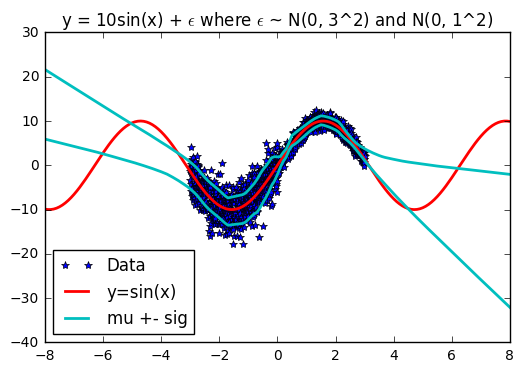

In [28]:
# Get Unknown dataset and test 
x_sample = np.arange(-8, 8 + 0.1, 0.1)
x_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

y_sample = np.zeros([x_sample.shape[0], 1])

for i in range(x_sample.shape[0]):
    y_sample[i, 0] = 10 * np.sin(x_sample[i,0])
        
# output for ensemble network
out_mu_sample  = np.zeros([x_sample.shape[0], len(networks)])
out_sig_sample = np.zeros([x_sample.shape[0], len(networks)])

# output for single network
out_mu_single  = np.zeros([x_sample.shape[0], 1])
out_sig_single = np.zeros([x_sample.shape[0], 1])

for i in range(len(networks)):
    mu_sample, sig_sample = sess.run([output_mu_list[i], output_sig_list[i]], 
                                      feed_dict = {x_list[i]: x_sample})

    out_mu_sample[:,i]  = np.reshape(mu_sample, (x_sample.shape[0]))
    out_sig_sample[:,i] = np.reshape(sig_sample, (x_sample.shape[0]))

    out_mu_single[:,0]  = np.reshape(mu_sample[:,0], (x_sample.shape[0]))
    out_sig_single[:,0] = np.reshape(sig_sample[:,0], (x_sample.shape[0]))

out_mu_sample_final  = np.mean(out_mu_sample, axis = 1)
out_sig_sample_final = np.sqrt(np.mean(out_sig_sample + np.square(out_mu_sample), axis = 1) - np.square(out_mu_sample_final))

plt.figure(1)
plt.plot(data_x, data_y, 'b*')
plt.plot(x_sample, y_sample, 'r', linewidth = 2)
plt.plot(x_sample, out_mu_sample_final - out_sig_sample_final, 'c', linewidth = 2)
plt.plot(x_sample, out_mu_sample_final + out_sig_sample_final, 'c', linewidth = 2)

plt.legend(['Data', 'y=sin(x)', 'mu +- sig'], loc='best')
plt.title('y = 10sin(x) + $\epsilon$ where $\epsilon$ ~ N(0, 3^2) and N(0, 1^2)')

plt.show()

## Comparison between Ensemble and Single network

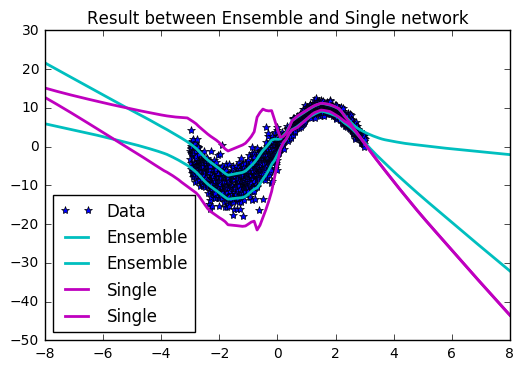

In [30]:
plt.plot(data_x, data_y, 'b*')
plt.plot(x_sample, out_mu_sample_final - out_sig_sample_final, 'c', linewidth = 2)
plt.plot(x_sample, out_mu_sample_final + out_sig_sample_final, 'c', linewidth = 2)
plt.plot(x_sample, out_mu_single + out_sig_single, 'm', linewidth = 2)
plt.plot(x_sample, out_mu_single - out_sig_single, 'm', linewidth = 2)

plt.legend(['Data', 'Ensemble', 'Ensemble', 'Single', 'Single'], loc='best')
plt.title('Result between Ensemble and Single network')

plt.show()